# Authors
1. Mateusz Nowicki
2. Jędrzej Miczke 156068

### Imports

In [352]:

import numpy as np
import math

import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from numpy.lib.stride_tricks import as_strided

### Data reading 

In [353]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels











### Dataframes creation

In [354]:
def read_and_concatenate_files(path_out):
    """
    Reads files in chunks of 6, concatenates the data, and creates DataFrames for each chunk.
    
    Parameters:
        files (list of str): List of file paths to load the data from.
        dx (float): Spacing between columns (default is 5.1065).
        dt (float): Time step for the frequency (default is 0.0016 seconds).
        
    Returns:
        List of pandas DataFrames: List of DataFrames for each chunk of 6 files.
    """
    dx=5.106500953873407
    dt=0.0016
    dataframes = []
    files = glob.glob(path_out+"*")
    files.sort()
    
    # Loop over the files in chunks of 6
    for i in range(0, len(files), 6):
        data_chunk = []
        
        # Process the current chunk of 6 files
        for file in files[i:i+6]:
            data_chunk.append(np.load(file))
        
        # Concatenate the data
        data_chunk = np.concatenate(data_chunk)
        
        # Retrieve start time for each chunk (using the first file in the chunk)
        time_start = datetime.datetime.strptime('2024-05-07 ' + files[i].split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
        
        # Create pandas date range (assumes each chunk has the same length)
        index = pd.date_range(start=time_start, periods=len(data_chunk), freq=f'{dt}s')
        
        # Create columns based on dx
        columns = np.arange(len(data_chunk[0])) * dx
        
        # Create DataFrame
        df = pd.DataFrame(data=data_chunk, index=index, columns=columns)
        
        # Store the DataFrame in the list
        dataframes.append(df)
    
    return dataframes


### Basic preprocessing

In [355]:
def basic_preprocessing(df, minmax=False,ret_dataframe=False):
    """
    Preprocesses a DataFrame by centering, taking absolute values,
    clipping outliers, and optionally applying min-max scaling.

    Parameters:
        df (pd.DataFrame): Input DataFrame to preprocess.
        minmax (bool): If True, applies min-max scaling to the data.

    Returns:
        pd.DataFrame: A new DataFrame with altered data, preserving the original index and columns.
    """
    # Make a copy of the input DataFrame to avoid modifying it
    new_df = df.copy()
    
    # Center the data by subtracting the mean
    new_df -= new_df.mean()
    
    # Take the absolute value
    new_df = np.abs(new_df)
    
    # Clip outliers at the 3rd and 99th percentiles
    low, high = np.percentile(new_df.values, [3, 99])  # Use .values to apply percentiles to the entire data
    
    new_df = np.clip(new_df, low, high)
    
    # Apply min-max scaling if specified
    if minmax:
        new_df = (new_df - low) / (high - low)
        new_df[new_df < 0] = 0  # Ensure lower values are clipped correctly

    # Return as DataFrame to preserve structure
    if ret_dataframe:
        return pd.DataFrame(new_df, index=df.index, columns=df.columns)
    else:
        numpy_array = new_df.to_numpy()
        return numpy_array

### Casting to grayscale image format 

In [356]:
'''binarization of data, setting a number of bins for data'''
# def convert_grayscale_data(df,scaling_parameter,ret_dataframe=True):
#     data = df.to_numpy()
#     data = np.floor(data *scaling_parameter)
#     data = data.astype(np.uint8)
#     if ret_dataframe:
#         return pd.DataFrame(data, index=df.index, columns=df.columns)
#     else:
#         return data

'binarization of data, setting a number of bins for data'

### Denoising and preprocessing

Unfortunately the data is inherently very  noisy which makes it difficult to track the moving vehicles  without some kind of denoising. The preprocessing strategies are as mentioned here:


1. function - mean_denoising

First of all we observed the time fragments where there in our opinion no moving vehicle was visible, we took the mean of the values of the pixels for such scenario, and subtracted it (multiplied by some scaling constant) from our images which we were processing. We subtracted the mean from the values below some threshold, not to shift the values of the whole pixels, but just to get rid of the noise,  acting in similar way to the low pass filter. We spotted that first 3 files 090017-090037 seem to contain only noise. functionmean_denosing

2.  function -column_denosing

The second approach was similar however we took the mean separately for each column, with assumption that maybe the noise is somehow specific to each point in space

3. function - normalizing_columns

We spotted that the certain columns, so certain points in space have overall increased, response of the sensor, so in order to fix it, we set sum for each column to be equal

4. low_pass_filter_percentile

In each column , sets all the pixels below value for a given percentile to zero. It serves as kind of low pass filter

5. clip_above_precentile
    
This function on the other hand, sets the pixels whose values exceed the value for a given percentile to the value of this percentile. This halps with the uneven saturation of the
lines for different vehicles, probably for the heavy vehicles, like tram, the response of the sensors is much greater, due to its mass.

6. gamma_correction
    
Gamma correction performed in order to , increase the saturation after the denoising, to make the 'lines' standout more from the remnants of the noise




In [357]:





'''this filter is used in order to get rid of the noise in each column, basicaly we check the distribution of each column value, and clip the value above some percentile, which is
empirically tweaked by us '''

def low_pass_filter_percentile(image, percentile=60, ret_dataframe=True):
    """
    Applies a low-pass filter on a 2D image. For each column, values below a specified percentile are set to 0.
    
    Parameters:
    - image: pd.DataFrame or numpy array. Input 2D image to filter.
    - percentile: int. Percentile value (0-100) to use as the threshold.
    - ret_dataframe: bool. Whether to return the result as a DataFrame (if input is a DataFrame).
    
    Returns:
    - Filtered image (DataFrame or numpy array).
    """
    # Convert DataFrame to numpy array if needed
    data = image.to_numpy()
    
    # Create an array of column-wise percentiles
    column_percentiles = np.percentile(data, percentile, axis=0)
    
    # Apply the filter: set values below the percentile to 0
    filtered_data = np.where(data >= column_percentiles, data, 0)

    
    # Return in the appropriate format
    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(filtered_data, index=image.index, columns=image.columns)
    else:
        return filtered_data
    

def low_pass_filter_all(image,percentile_thresh =90,ret_dataframe = True):
    data = image.to_numpy()

    percentile = np.percentile(data,percentile_thresh)

    filtered_data = np.where(data<=percentile,0,data)

    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(filtered_data, index=image.index, columns=image.columns)
    else:
        return filtered_data






'''just subtracting the mean of the noise observed on the data, where only noise were'''
def mean_denoising(noise,image,constant, ret_dataframe = True,threshold=None):
    img = image.to_numpy()
    if not threshold:
        threshold = np.median(img)
    mean_of_noise = np.mean(noise)
    img = np.where(img>threshold, img, np.maximum(img-(constant*mean_of_noise),0))
    print(np.all(img>=0))
    if ret_dataframe:
        return pd.DataFrame(img, index=image.index, columns=image.columns)
    else:
        return img

    
'''subtracting the mean of the noise but for each column- each measuring point separatley '''
def column_denoising(noise,image,constant,ret_dataframe = True, threshold=None):
    img = image.to_numpy()
    if not threshold:
        threshold = np.median(img)
    mean_of_noise_columns = np.mean(noise,axis=0)
    subtracted =  img - (constant*mean_of_noise_columns)
    subtracted = np.maximum(0,subtracted)
    to_return= np.where(img>threshold,img,subtracted)
    if ret_dataframe:
        return pd.DataFrame(to_return, index=image.index, columns=image.columns)
    else:
        to_return

# def normalizing_columns(image):
#     pass


    
'''performed due to the fact that some of the columns as whole seemed to be more saturated even though no vehicle passed there '''
def normalizing_columns(image, target_sum=1, ret_dataframe=True):
    """
    Normalize each column of the given image so that the sum of each column equals the target_sum.

    Parameters:
    - image: pd.DataFrame or np.ndarray
        The input image with columns to normalize.
    - target_sum: float
        The desired sum of each column after normalization (default is 1).
    - ret_dataframe: bool
        If True, returns a DataFrame; otherwise, returns a NumPy array.

    Returns:
    - normalized: pd.DataFrame or np.ndarray
        The normalized image with column sums equal to target_sum.
    """
    if isinstance(image, pd.DataFrame):
        img = image.to_numpy()
    else:
        img = np.array(image)

    # Calculate the sum of each column
    col_sums = np.sum(img, axis=0)
    
    # Avoid division by zero
    col_sums[col_sums == 0] = 1
    
    # Normalize each column to have the desired sum
    normalized = img / col_sums * target_sum

    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(normalized, index=image.index, columns=image.columns)
    else:
        return normalized
''''''


'''used at the end to enhance the remaining data, after the denosing step'''
def gamma_correction(image, gamma=1.2,ret_dataframe=True):
    # Ensure the image is in the range [0, 1]
    img = image.to_numpy()
    img = np.clip(img, 0, 1)
    
    # Apply gamma correction
    corrected_img = np.power(img, gamma)
    if ret_dataframe:
        return pd.DataFrame(corrected_img, index=image.index, columns=image.columns)
            
    return corrected_img


def clip_above_percentile(image, percentile_thresh=80, ret_dataframe=True):
    """
    Clips pixel values in the image above a specified percentile.

    Parameters:
    - image: Input image (DataFrame or numpy array).
    - percentile_thresh: The percentile threshold to clip the pixel values.
    - ret_dataframe: Whether to return the result as a DataFrame (if input is a DataFrame).

    Returns:
    - Clipped image (DataFrame or numpy array).
    """
    # Convert image to numpy array if it is a DataFrame
    if isinstance(image, pd.DataFrame):
        img = image.to_numpy()
    else:
        img = image
    
    # Find the specified percentile value
    percentile_value = np.percentile(img, percentile_thresh)
    
    # Clip the values above the specified percentile
    clipped_img = np.where(img > percentile_value, percentile_value, img)
    
    # Return the result in the appropriate format
    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(clipped_img, index=image.index, columns=image.columns)
    else:
        return clipped_img


### Time downsampling

We decided to perform the time downsampling. First of all the dimensions of the data are very irregular i.e for each "picture" created by concatenation of 6 recordings we obtain  dimensions 37500 X 52 and to fit a "slanted" line would be difficult because the tiniest change in the vehicle velocity would result in rapid change of the line slope in its neighbourhood and the lines corresponding to the vehicles would not be 'straight'. Instead for each vehicles we would find many short fragmented lines corresponding to it's movement. 

We can interpret the dimensions of the data in the following way: for each of 52  points in space the accoustinc sensing
has been captured 37500 times..we decided to aggregate every 50 consecutive time measurments into one, reducing the dimensionality from 37500 X 52 to 750 X 52. 100 empirically seemed to give the best result, The bigger numbers also looked great but it would also mean bigger loose of accuracy then.

Unfortunately as mentioned we are aware that this way "loose" some information when assesing the speed of the vehicles, but at least it may faciliate us being able to detect this vehicle movement.



In [358]:
def downsampling_time_max(df,window_size=50,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    
def downsampling_time_max_mean(df,window_size=50,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data_max = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)
    downsampled_data_mean = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)
    downsampled_data = downsampled_data_max - downsampled_data_mean

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    

def downsampling_time_mean(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute mean
    downsampled_data = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)


    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data


def downsampling_time_median(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.median(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    

### morphologic operations

The morphologic operations are usefull in order to manipulate the image structure. We dont use all of the functions below, but we utilize for example dilation , in order to connect the lines for 
vehicles.

In [359]:
def get_structuring_element(kernel):
    """
    Generate a structuring element based on the kernel input:
    - If int, creates a square structuring element (kernel, kernel).
    - If tuple, creates a rectangular structuring element (kernel[0], kernel[1]).
    - If already a structuring element, returns it as is.
    """
    if isinstance(kernel, int):
        return cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel, kernel))
    elif isinstance(kernel, tuple):
        return cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel[1], kernel[0]))
    elif isinstance(kernel, np.ndarray):  # Assume it's already a structuring element
        return kernel
    else:
        raise ValueError("Kernel must be an int, tuple, or a valid structuring element (numpy array).")





def morphological_opening(image, kernel):
    """Standard morphological opening (erosion followed by dilation)."""
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphological_closing(image, kernel):
    """Standard morphological closing (dilation followed by )."""
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


def proper_opening(image, kernel,ret_dataframe=True):
    """
    Proper opening: Q(f) = min(f, C(O(C(f))))
    as was on classes

    """
    
    img = image.to_numpy()
    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[1], kernel[0]))

    kernel = get_structuring_element(kernel)
    
    
    # Standard closing followed by opening
    closing = morphological_closing(img, kernel)
    opening = morphological_opening(closing, kernel)
    second_closing = morphological_closing(opening, kernel)

    # Proper opening: min(original, second_closing)
    proper_opened = np.minimum(img, second_closing)
    if ret_dataframe:
        return pd.DataFrame(proper_opened, index=image.index, columns=image.columns)
    else:
        return proper_opened

def proper_closing(image, kernel,ret_dataframe=True):
    """
    Proper closing: G(f) = max(f, O(C(O(f))))
    as was on classes
    """
    img = image.to_numpy()
    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[1], kernel[0]))

    kernel = get_structuring_element(kernel)
    
    # Standard opening followed by closing
    opening = morphological_opening(img, kernel)
    closing = morphological_closing(opening, kernel)
    second_opening = morphological_opening(closing, kernel)

    # Proper closing: max(original, second_opening)
    
    proper_closed = np.maximum(img, second_opening)
    
    if ret_dataframe:
        return pd.DataFrame(proper_closed, index=image.index, columns=image.columns)
    else:
        return proper_closed
def dilate(image, kernel, kernel_shape=cv2.MORPH_CROSS,ret_dataframe=True):
    """
    Perform morphological dilation on binary image
    """
    data = image.to_numpy()

    min_val = np.min(data)
    max_val = np.max(data)
    
    # Scale to the range [0, 255]
    normalized_image = (data - min_val) / (max_val - min_val) * 255
    normalized_image = np.clip(normalized_image, 0, 255).astype(np.uint8)

    # if len(kernel) ==1:
    #     kernel = cv2.getStructuringElement(kernel_shape, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[1]))

    kernel = get_structuring_element(kernel)

    dilated_image = cv2.dilate(data, kernel)
    if ret_dataframe:
        return pd.DataFrame(dilated_image, index=image.index, columns=image.columns)
    else:
        return dilated_image



def erode(image, kernel=3, kernel_shape=cv2.MORPH_RECT,ret_dataframe=True):
    """
    Perform morphological erosion on binary image 

    """
    img = image.to_numpy()
    # if len(kernel)==1:
    #     kernel = cv2.getStructuringElement(kernel_shape, (kernel[0], kernel[0]))
    # elif len(kernel) ==2:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel[0], kernel[1]))

    kernel = get_structuring_element(kernel)

    eroded_image = cv2.erode(img, kernel)
    
    if ret_dataframe:
        return pd.DataFrame(eroded_image, index=image.index, columns=image.columns)
    else:
        return eroded_image


def continous_dilation(image, structuring_element,ret_dataframe):
    """
    Perform continuous domain dilation on normal image like [0-255] range.
    """
    img = image.to_numpy()
    
    if len(structuring_element.flatten()) >2:
        kernel_h, kernel_w = structuring_element.shape  # Get kernel dimensions
    else:
        kernel_h, kernel_w = structuring_element[0], structuring_element[1]

   
    # Padding the image to handle boundaries
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # Define the shape and strides for the sliding window
    shape_strided = (
        img.shape[0], img.shape[1], kernel_h, kernel_w
    )
    strides = padded_image.strides + padded_image.strides
    
    # Create sliding window view
    image_strides = as_strided(padded_image, shape_strided, strides)
    
    # Perform dilation (max operation over the window)
    image_return = np.max(image_strides, axis=(2, 3))

    if ret_dataframe:
        return pd.DataFrame(image_return, index=image.index, columns=image.columns)
    else:
        return image_return
    
    
    

def continous_erosion(image, structuring_element,ret_dataframe=True):
    """
    Perform continuous domain erosion same as continous dilation but minimum of sliding window instead of maximum taken.

    """
    img = image.to_numpy()
    if len(structuring_element.flatten()) >2:
        kernel_h, kernel_w = structuring_element.shape  # Get kernel dimensions
    else:
        kernel_h, kernel_w = structuring_element[0], structuring_element[1]
    
    # Padding the image to handle boundaries
    pad_h, pad_w = kernel_h // 2, kernel_w // 2
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    # Define the shape and strides for the sliding window
    shape_strided = (
        img.shape[0], img.shape[1], kernel_h, kernel_w
    )
    strides = padded_image.strides + padded_image.strides
    
    # Create sliding window view
    image_strides = as_strided(padded_image, shape_strided, strides)
    
    # Perform dilation (max operation over the window)
    image_return = np.min(image_strides, axis=(2, 3))
    
    if ret_dataframe:
        return pd.DataFrame(image_return, index=image.index, columns=image.columns)
    else:
        return image_return

def automedian(image, kernel,ret_dataframe=True):
    """
    Automedian filter: A(f) = max(O(C(O(f))), Q(f))
    as was on the clasees
    """
    img = image.to_numpy()
    
    
    # Step 1: O(C(O(f)))
    kernel = get_structuring_element(kernel)
    opening = morphological_opening(img, kernel)
    closing_after_opening = morphological_closing(opening, kernel)
    second_opening = morphological_opening(closing_after_opening, kernel)
    
    # Step 2: Q(f)
    proper_opened = proper_opening(image, kernel=kernel)
    
    # Step 3: A(f) = max(O(C(O(f))), Q(f))
    automedian_filtered = np.maximum(second_opening, proper_opened)
    
    if ret_dataframe:
        return pd.DataFrame(automedian_filtered, index=image.index, columns=image.columns)
    else:
        return automedian_filtered
    

def create_diag_kernel(size,bottom_top=True):
    '''creating diagonale kernel maybe useuful for diagonla line detection? '''
    kernel = np.zeros(size, dtype=np.uint8)  # Initialize kernel with zeros

    rows, cols = size
    mid_row, mid_col = rows // 2, cols // 2

    if bottom_top:
        # Fill bottom-left and top-right
        kernel[:mid_row, mid_col:] = 1  # Top-right
        kernel[mid_row:, :mid_col] = 1  # Bottom-left
    else:
        # Fill top-left and bottom-right
        kernel[:mid_row, :mid_col] = 1  # Top-left
        kernel[mid_row:, mid_col:] = 1  # Bottom-right
    return kernel






### thresholding function

The thresholding function ,will be necessary at some point, in order to be able to apply line detecting function such as hugh lines, otsu binarization seem like a good choices, since the data after allthe previous preprocessing has rather uniform saturation intensity, in whole picture so adaptive binarization cpuld not work well.

In [360]:
import cv2
import pandas as pd
import numpy as np

def thresholding_otsu_function(df, ret_dataframe=True):
    # Convert DataFrame to numpy array if not already
    if isinstance(df, pd.DataFrame):
        data = df.to_numpy()
    else:
        data = df
    
    # Normalize data to range [0, 255]
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255
    
    # Convert to unsigned 8-bit integer
    data = data.astype(np.uint8)
    
    # Apply Otsu's thresholding
    _, binary_image = cv2.threshold(data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Ensure the output image is binary
    unique_values = np.unique(binary_image)
    print("Unique values in the output image:", unique_values)
    
    # Return the result in the desired format
    if ret_dataframe and isinstance(df, pd.DataFrame):
        return pd.DataFrame(binary_image, index=df.index, columns=df.columns)
    else:
        return binary_image


### contour edge detection

Here the high pass filters are stored. They are used in order to amplify the reponse on the edgess of the image. This serves well in amplyfing the reponse of the lines, when is applied on the
duly denoised picture. The sobel_vertical function proves to work well , as we are mainly interested in searching for the vertical edges, because the remaining noise in our case is mainly horizontal one 

In [361]:
import numpy as np
import cv2
import pandas as pd

def sobel_filter(image, vertical_weight=1.5, ret_dataframe=True):
    """
    Applies a Sobel filter to detect edges in an image, with enhanced vertical edge detection.
    
    Parameters:
    - image: pd.DataFrame or numpy array. Input 2D image to filter.
    - vertical_weight: Weight to emphasize vertical edge detection (default = 1.5).
    - ret_dataframe: bool. Whether to return the result as a DataFrame (if input is a DataFrame).
    
    Returns:
    - Edge-detected image (DataFrame or numpy array).
    """
    # Convert DataFrame to numpy array if needed
    if isinstance(image, pd.DataFrame):
        data = image.to_numpy()
    else:
        data = image

    min_val = np.min(data)
    max_val = np.max(data)
    
    # Scale to the range [0, 255]
    normalized_image = (data - min_val) / (max_val - min_val) * 255
    normalized_image = np.clip(normalized_image, 0, 255).astype(np.uint8)

    
    # Apply Sobel filters in both X and Y directions (horizontal and vertical edges)
    grad_x = cv2.Sobel(normalized_image, cv2.CV_64F, 1, 0, ksize=3)  # Vertical edges (horizontal gradients)
    grad_y = cv2.Sobel(normalized_image, cv2.CV_64F, 0, 1, ksize=3)  # Horizontal edges (vertical gradients)
    
    # Combine the gradients, giving more weight to vertical edges for slanted line detection
    edge_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    weighted_edge_magnitude = np.sqrt((grad_x**2) + (vertical_weight * grad_y**2))
    
    # Normalize the result to range [0, 255]
    edge_magnitude = np.clip(edge_magnitude, 0, 255).astype(np.uint8)
    weighted_edge_magnitude = np.clip(weighted_edge_magnitude, 0, 255).astype(np.uint8)
    
    # Return in the appropriate format
    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(weighted_edge_magnitude, index=image.index, columns=image.columns)
    else:
        return weighted_edge_magnitude
    

    import cv2
import numpy as np
import pandas as pd

def sobel_filter_vertical(image, vertical_weight=1.5, ret_dataframe=True):
    """
    Applies a Sobel filter to detect vertical edges in an image, with optional weighting to enhance vertical edge detection.
    
    Parameters:
    - image: pd.DataFrame or numpy array. Input 2D image to filter.
    - vertical_weight: Weight to emphasize vertical edge detection (default = 1.5, this can be adjusted).
    - ret_dataframe: bool. Whether to return the result as a DataFrame (if input is a DataFrame).
    
    Returns:
    - Edge-detected image (DataFrame or numpy array).
    """
    # Convert DataFrame to numpy array if needed
    if isinstance(image, pd.DataFrame):
        data = image.to_numpy()
    else:
        data = image

    min_val = np.min(data)
    max_val = np.max(data)
    
    # Scale to the range [0, 255]
    normalized_image = (data - min_val) / (max_val - min_val) * 255
    normalized_image = np.clip(normalized_image, 0, 255).astype(np.uint8)

    # Apply Sobel filter in the horizontal direction (vertical edges)
    grad_x = cv2.Sobel(normalized_image, cv2.CV_64F, 1, 0, ksize=3)  # Vertical edges (horizontal gradients)
    
    # Apply a small weight to vertical edges if needed (controlled by vertical_weight)
    weighted_grad_x = grad_x * vertical_weight
    
    # Normalize the result to the range [0, 255] for visualization
    weighted_grad_x = np.clip(weighted_grad_x, 0, 255).astype(np.uint8)

    # Return in the appropriate format
    if ret_dataframe and isinstance(image, pd.DataFrame):
        return pd.DataFrame(weighted_grad_x, index=image.index, columns=image.columns)
    else:
        return weighted_grad_x




### neighbourhood operations

the neighbourhood operations , were meant to connect the components - the lines, and get rid of the isolated components, the noise, but for now didnt seem to work that well.

In [362]:
import numpy as np
import pandas as pd
from scipy.ndimage import convolve

def connect_components(image, neighbours_num):
    """
    Connect components in an image: for each pixel with value 0, 
    set it to 1 if it has at least 'neighbours_num' non-zero neighbors.

    Parameters:
    - image: pd.DataFrame or numpy array. Input binary image to process.
    - neighbours_num: int. Minimum number of neighbors that must be non-zero 
      for a 0 pixel to be turned into a 1.

    Returns:
    - Image with connected components (DataFrame or numpy array).
    """
    # Convert DataFrame to numpy array if needed
    img = image.to_numpy() if isinstance(image, pd.DataFrame) else image

    # Define the kernel for a 3x3 neighborhood (including the central pixel)
    kernel = np.ones((3, 3), dtype=int)

    # Convolve the image with the kernel to count neighbors
    neighbor_counts = convolve(img, kernel, mode='constant', cval=0)

    # Only change the pixels where the center is 0 and the number of neighbors >= neighbours_num
    result_img = np.where((img == 0) & (neighbor_counts >= neighbours_num), 1, img)

    # Return as DataFrame if input was a DataFrame
    if isinstance(image, pd.DataFrame):
        return pd.DataFrame(result_img, index=image.index, columns=image.columns)
    else:
        return result_img

    

def delete_outliers(image,neighbours_num):

    img = image.to_numpy() if isinstance(image, pd.DataFrame) else image

    # Pad the image with 1-pixel border to handle edges
    padded_image = np.pad(img, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    # Create sliding window view with as_strided
    shape_strided = (img.shape[0], img.shape[1], 3, 3)
    strides = padded_image.strides + padded_image.strides
    windows = as_strided(padded_image, shape_strided, strides)

    # Count non-zero neighbors in each 3x3 window
    neighbor_counts = np.sum(windows, axis=(2, 3)) - img  # Subtract center pixel itself

    # Update pixels in the result image
    result_img = np.where((img == 1) & (neighbor_counts <= neighbours_num), 0, img)

    # Return as DataFrame if input was a DataFrame
    if isinstance(image, pd.DataFrame):
        return pd.DataFrame(result_img, index=image.index, columns=image.columns)
    else:
        return result_img
    


### Plotting function

Plotting function adjusted to plot 2 plots one next to each other

In [363]:


def plotting_function(df, to_preprocess=False):
    """
    Plots a single DataFrame or two DataFrames side by side.

    Parameters:
    - df: DataFrame or list of two DataFrames to plot.
    - to_preprocess: Whether to preprocess the data.
    """
    if isinstance(df, list) and len(df) == 2:
        # Case: Two DataFrames in a list
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

        for i, single_df in enumerate(df):
            new_df = single_df.copy()
            if to_preprocess:
                new_df = basic_preprocessing(single_df, minmax=False, ret_dataframe=True)

            low, high = np.percentile(new_df, [3, 99])
            norm = Normalize(vmin=low, vmax=high, clip=True)

            im = axes[i].imshow(new_df, interpolation='none', aspect='auto', norm=norm)
            axes[i].set_ylabel('time')
            axes[i].set_xlabel('space [m]')

            # Customize axis labels
            x_positions, x_labels = set_axis(single_df.columns)
            axes[i].set_xticks(x_positions, np.round(x_labels))
            y_positions, y_labels = set_axis(new_df.index.time)
            axes[i].set_yticks(y_positions, y_labels)

            # Add colorbar
            cax = fig.add_axes([axes[i].get_position().x1 + 0.01, axes[i].get_position().y0, 0.02, axes[i].get_position().height])
            #plt.colorbar(im, cax=cax)

        plt.show()

    elif isinstance(df, pd.DataFrame):
        # Case: Single DataFrame
        fig, ax = plt.subplots(figsize=(12, 16), constrained_layout=True)
        new_df = df.copy()
        if to_preprocess:
            new_df = basic_preprocessing(df, minmax=False, ret_dataframe=True)

        low, high = np.percentile(new_df, [3, 99])
        norm = Normalize(vmin=low, vmax=high, clip=True)

        im = ax.imshow(new_df, interpolation='none', aspect='auto', norm=norm)
        ax.set_ylabel('time')
        ax.set_xlabel('space [m]')

        # Add colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
        #plt.colorbar(im, cax=cax)

        # Customize axis labels
        x_positions, x_labels = set_axis(df.columns)
        ax.set_xticks(x_positions, np.round(x_labels))
        y_positions, y_labels = set_axis(new_df.index.time)
        ax.set_yticks(y_positions, y_labels)

        plt.show()

    else:
        raise ValueError("Input must be a DataFrame or a list of two DataFrames.")

 


# The workflow of the algorithm

### preprocessing testing

True
the data after the denoising on the left, the data before the denoising on the right


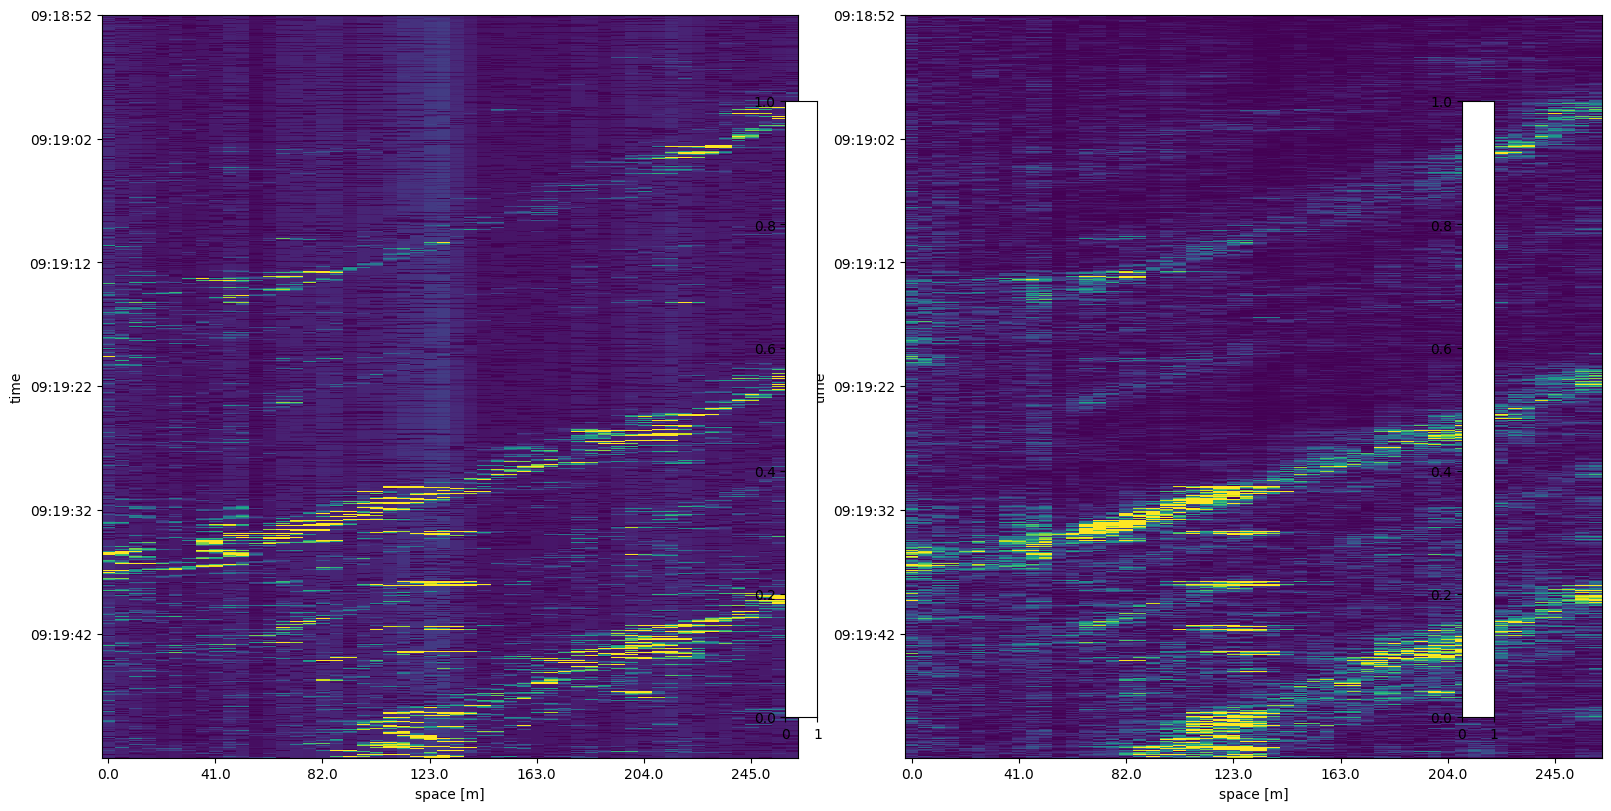

the data after the column normalizaiton on the left , the data before column normalization on the right


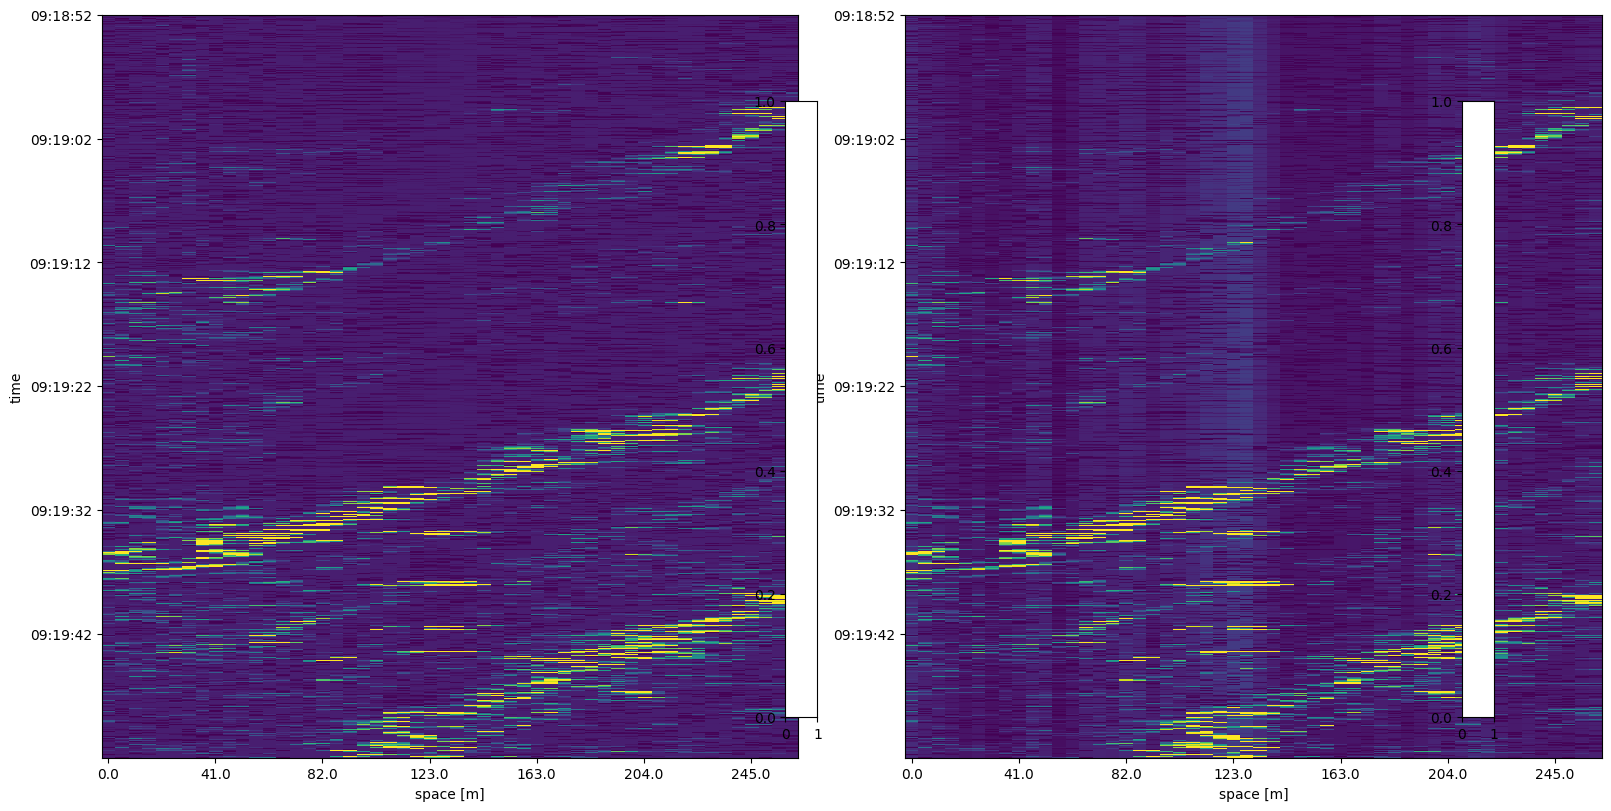

the data after the gamma_correction on the left , the data before the gamma_correction on the right


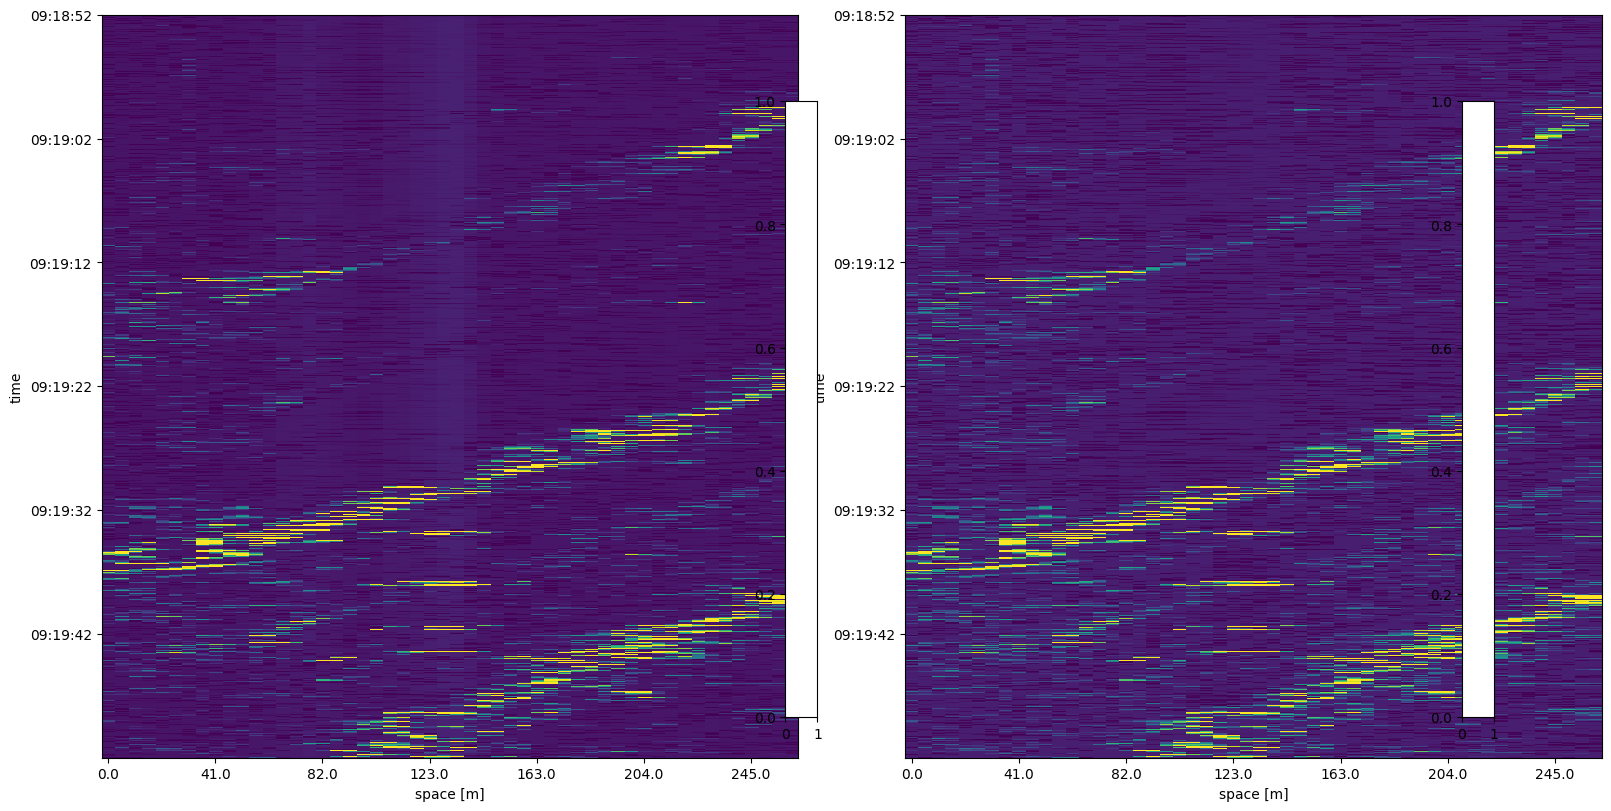

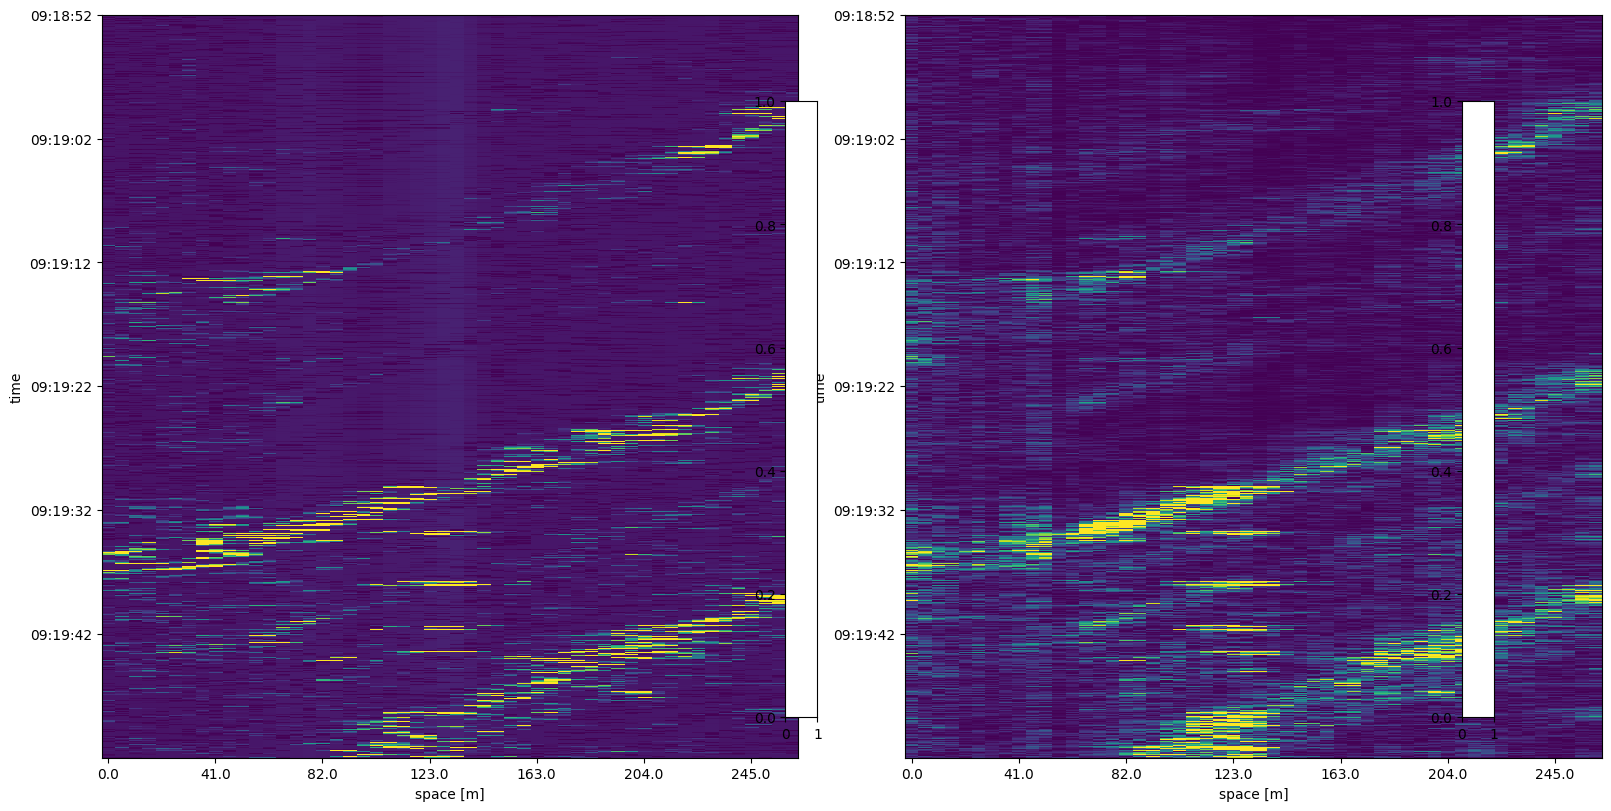

In [372]:
'''reading the data'''
path_out = 'jedrzej\\'

dfs = read_and_concatenate_files(path_out)

path_out_2 = 'noise\\'

dfs = dfs + read_and_concatenate_files(path_out_2)



'''normalizing the data subtracting the mean of the noise'''
data_mean_denoised = mean_denoising(dfs[2],dfs[0],3,True)
#display_two_plots(first,second)
print("the data after the denoising on the left, the data before the denoising on the right")
plotting_function([data_mean_denoised,dfs[0]],True)

# data_column_denoised =column_denoising(data_3,df_1,3,True)
# plotting_function([data_column_denoised,df_1],True)
# display_multiple_plots([first,third])

# print("data mean denoised = data_column denoised")
# print(np.all(data_mean_denoised==data_column_denoised))

# noise_subtracted = subtract_noise(data_3,df_2,True)
# plotting_function([noise_subtracted,df_2],True)

'''normalizing the columns since some columns are as whole more saturated than others'''
print("the data after the column normalizaiton on the left , the data before column normalization on the right")
mean_normalized = normalizing_columns(data_mean_denoised,1,True)
plotting_function([mean_normalized,data_mean_denoised],True)

'''enhancing the contrast on the image after denoising'''

mean_normalized_corrected = gamma_correction(mean_normalized,1.3)
print("the data after the gamma_correction on the left , the data before the gamma_correction on the right")
plotting_function([mean_normalized_corrected,mean_normalized],True)


'''comparison of the processed to this point data on the left, and original data on the right'''
plotting_function([mean_normalized_corrected,dfs[0]],True)
# columns_mean_normalized = normalizing_columns(data_column_denoised,1,True)
# plotting_function([columns_mean_normalized,data_column_denoised],True)




# data_2_denoised = mean_denoising(data_3,columns_normalized,3,True)
# plotting_function([data_2_denoised,columns_normalized])

## workflow 1

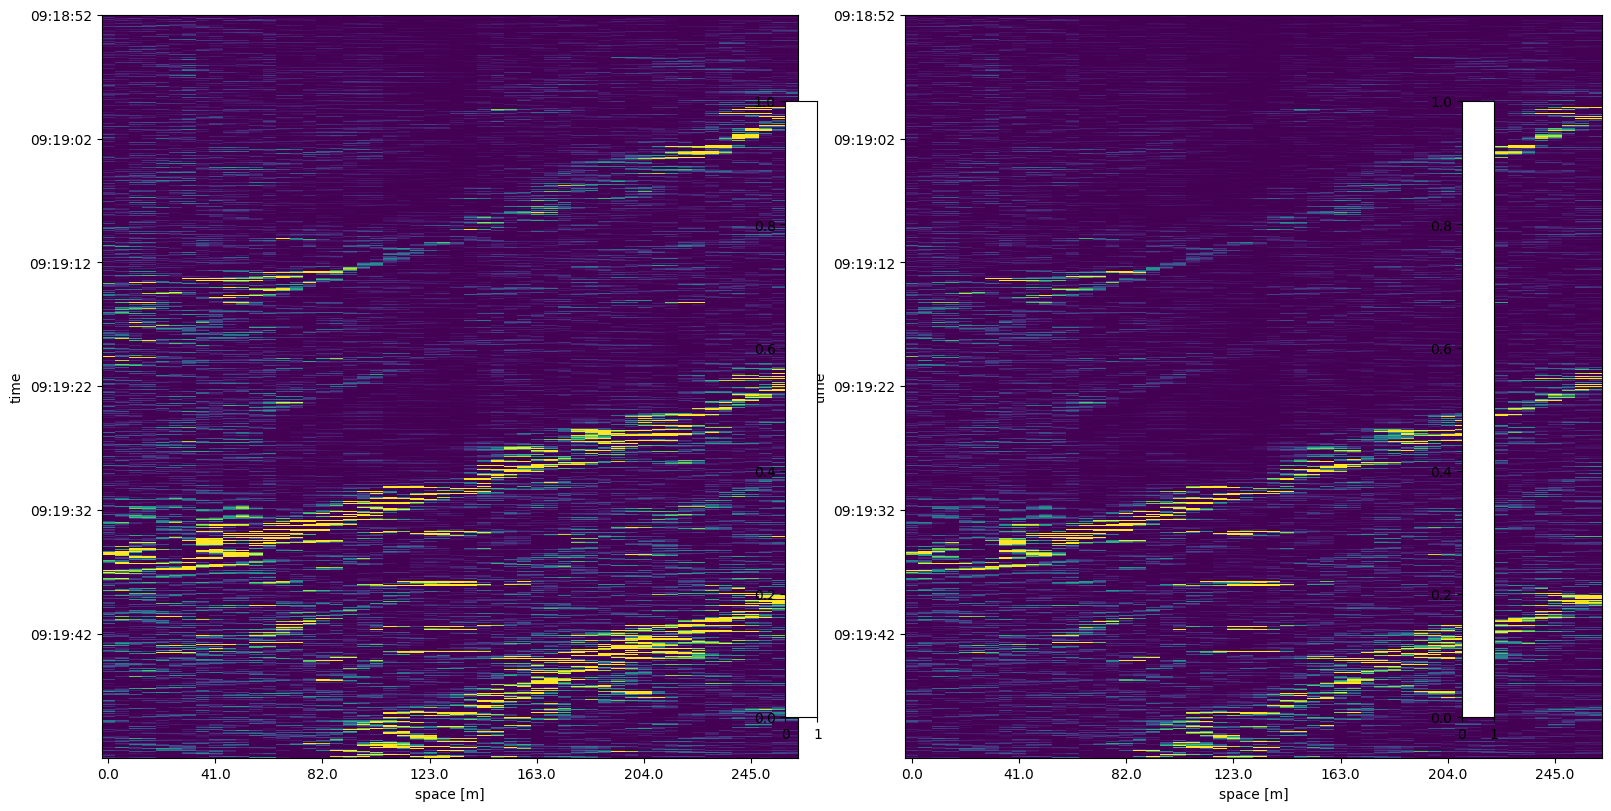

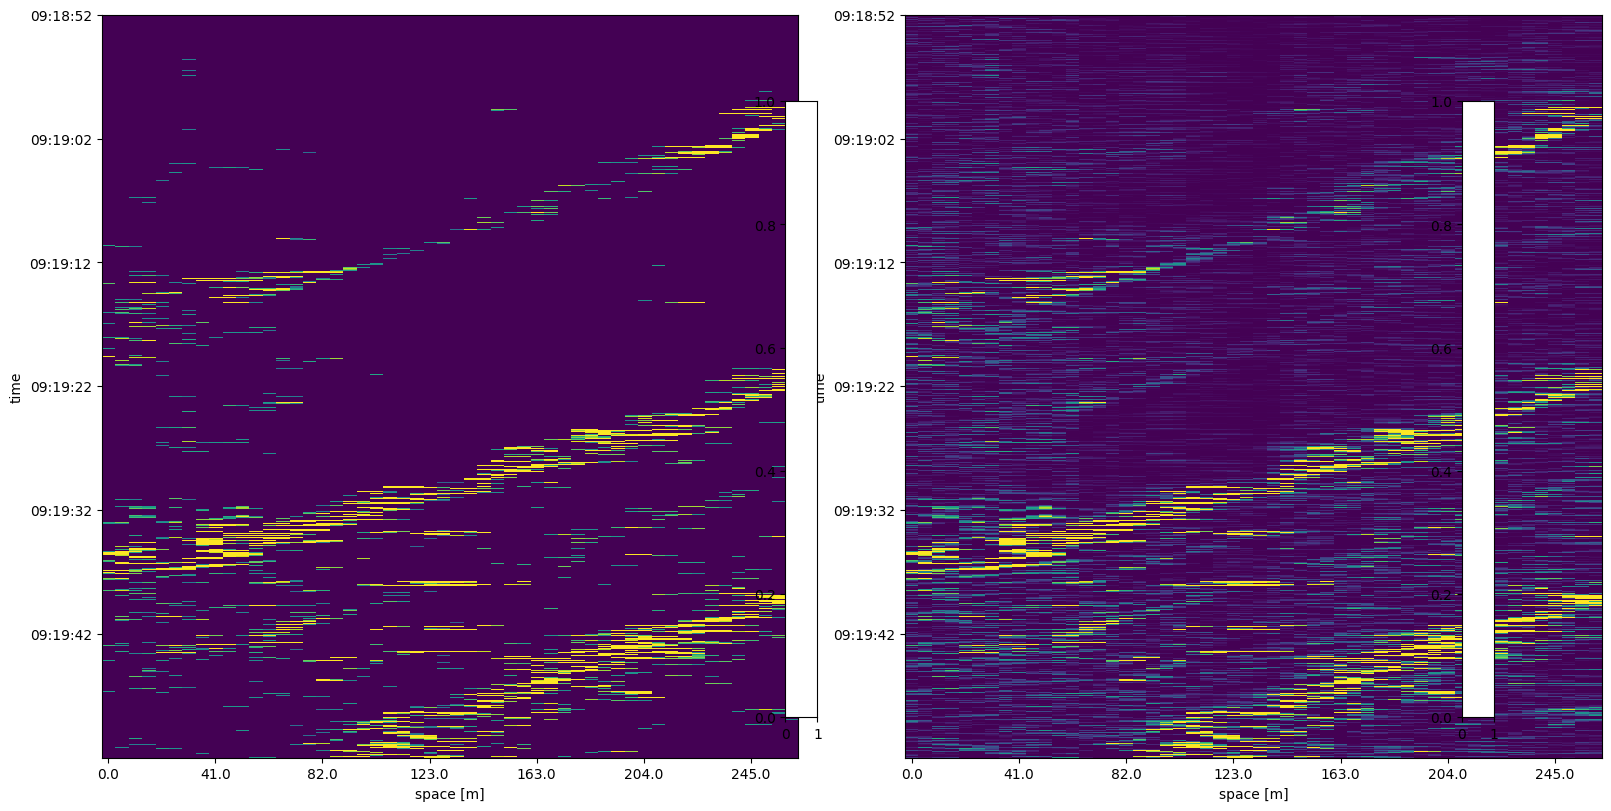

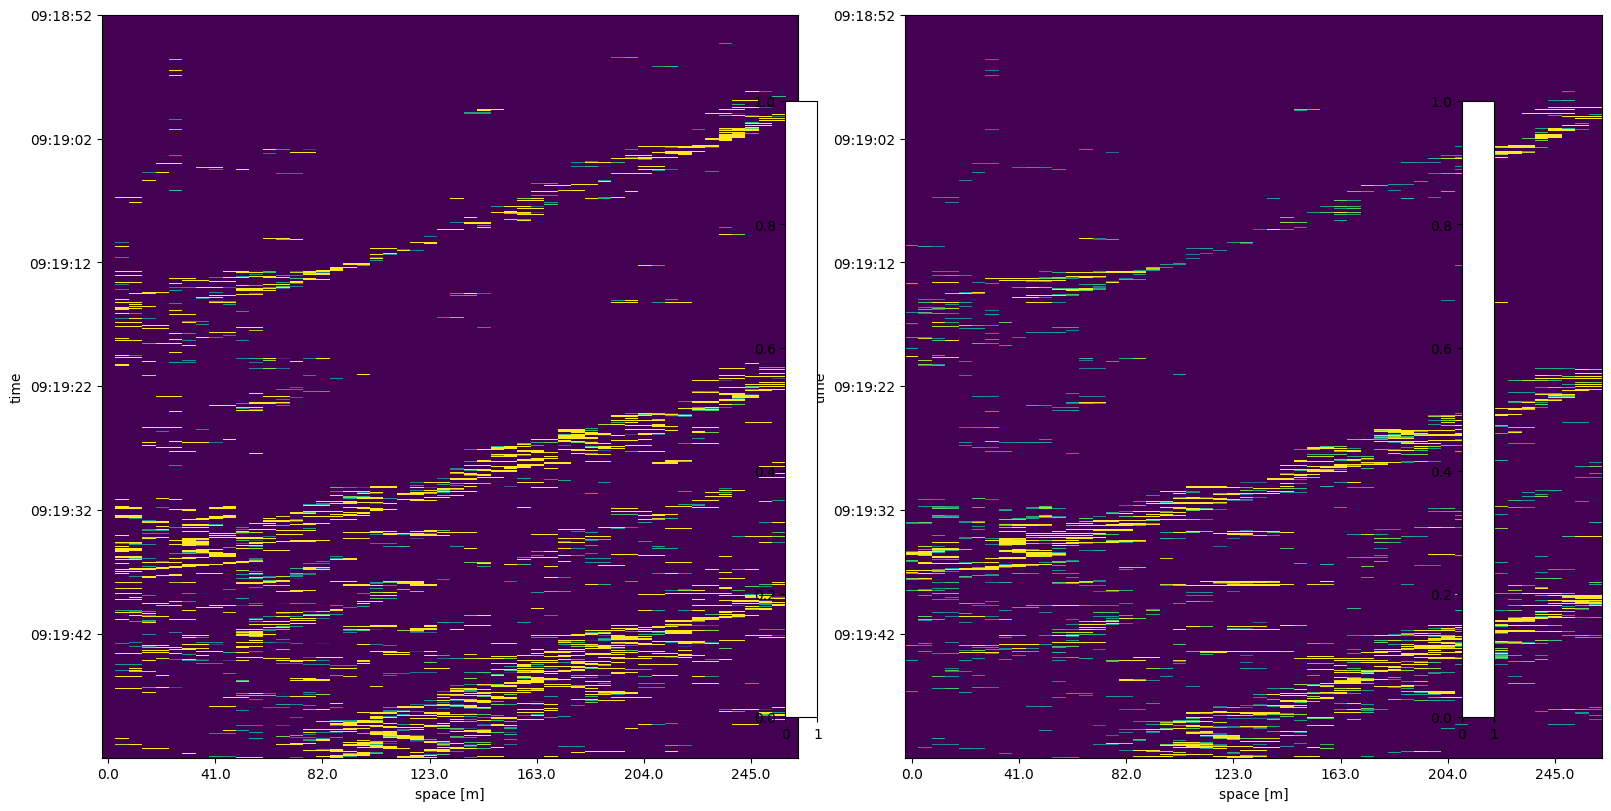

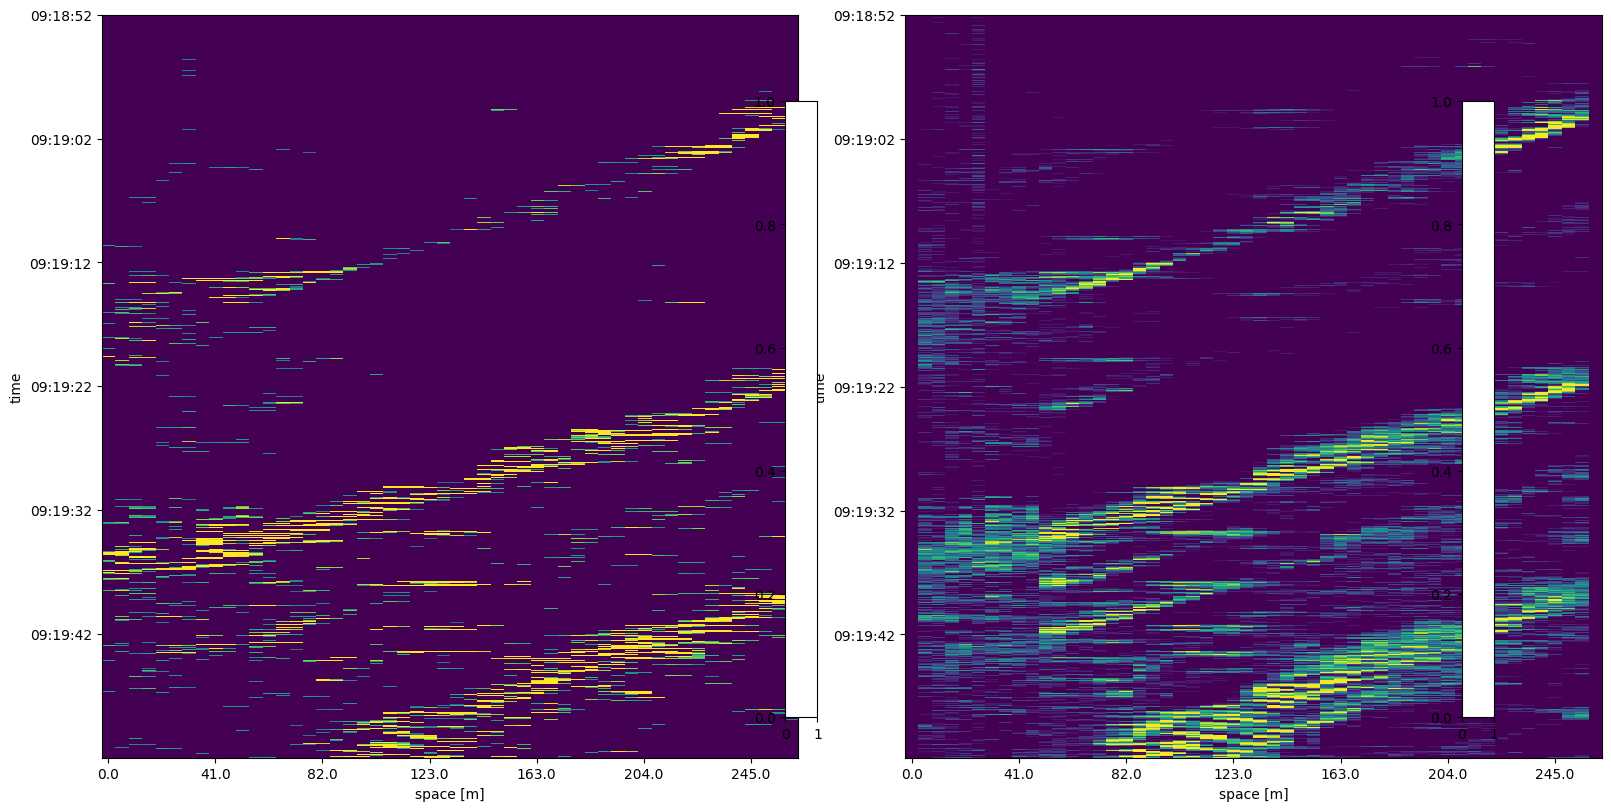

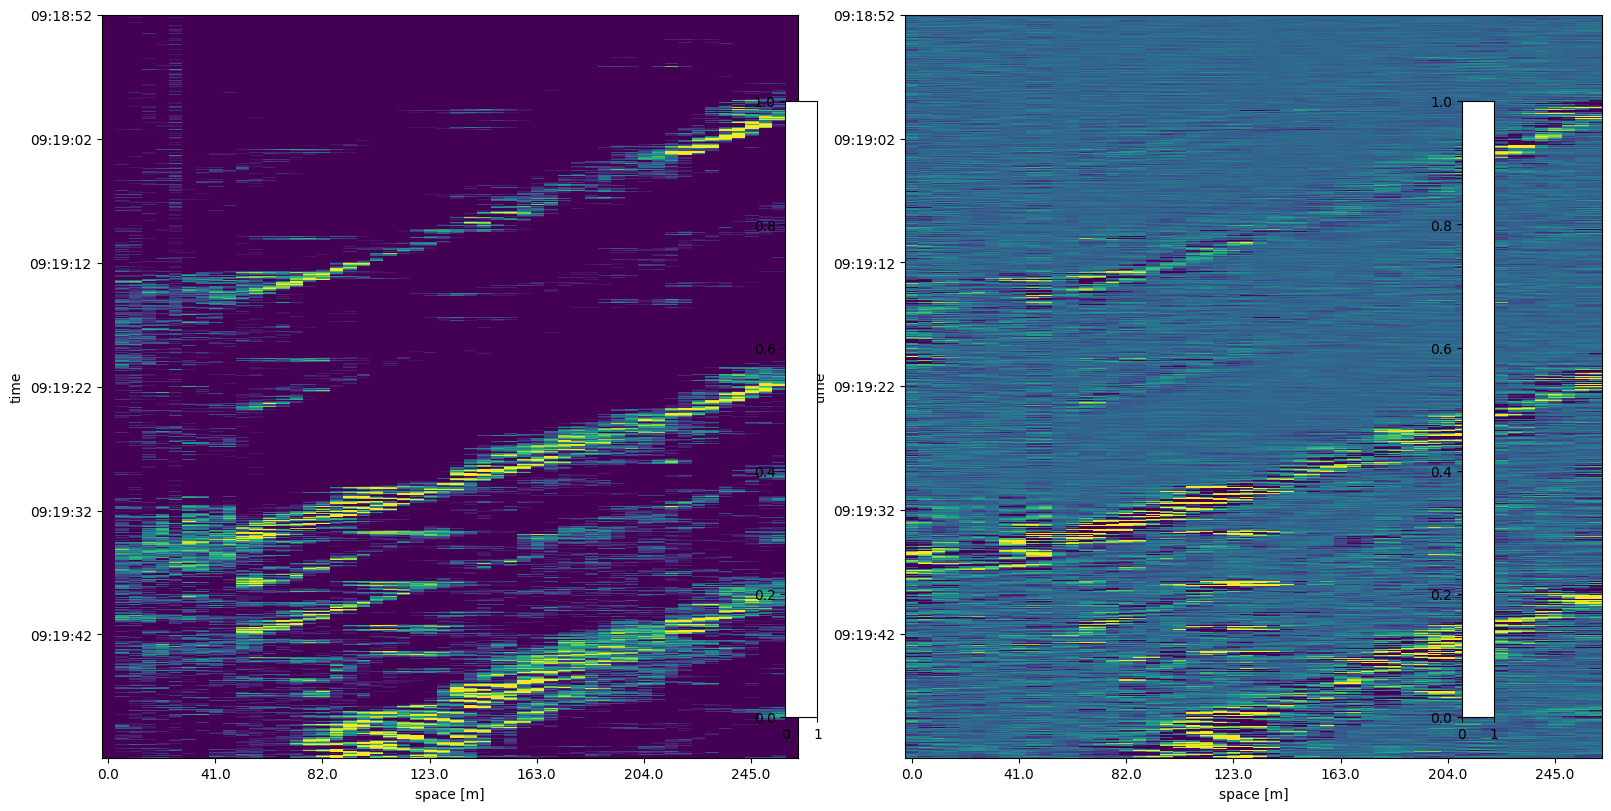

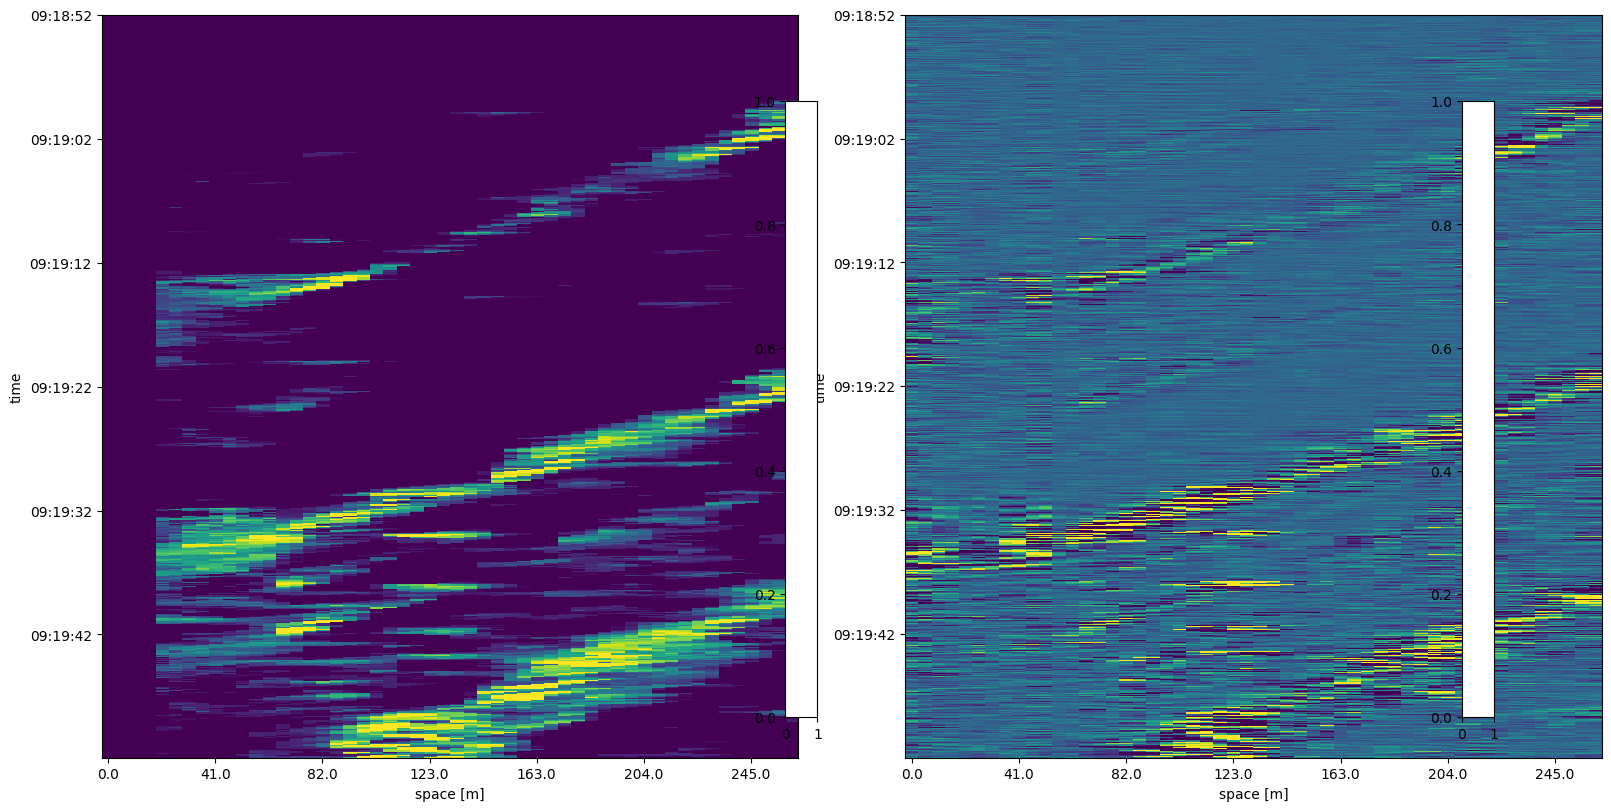

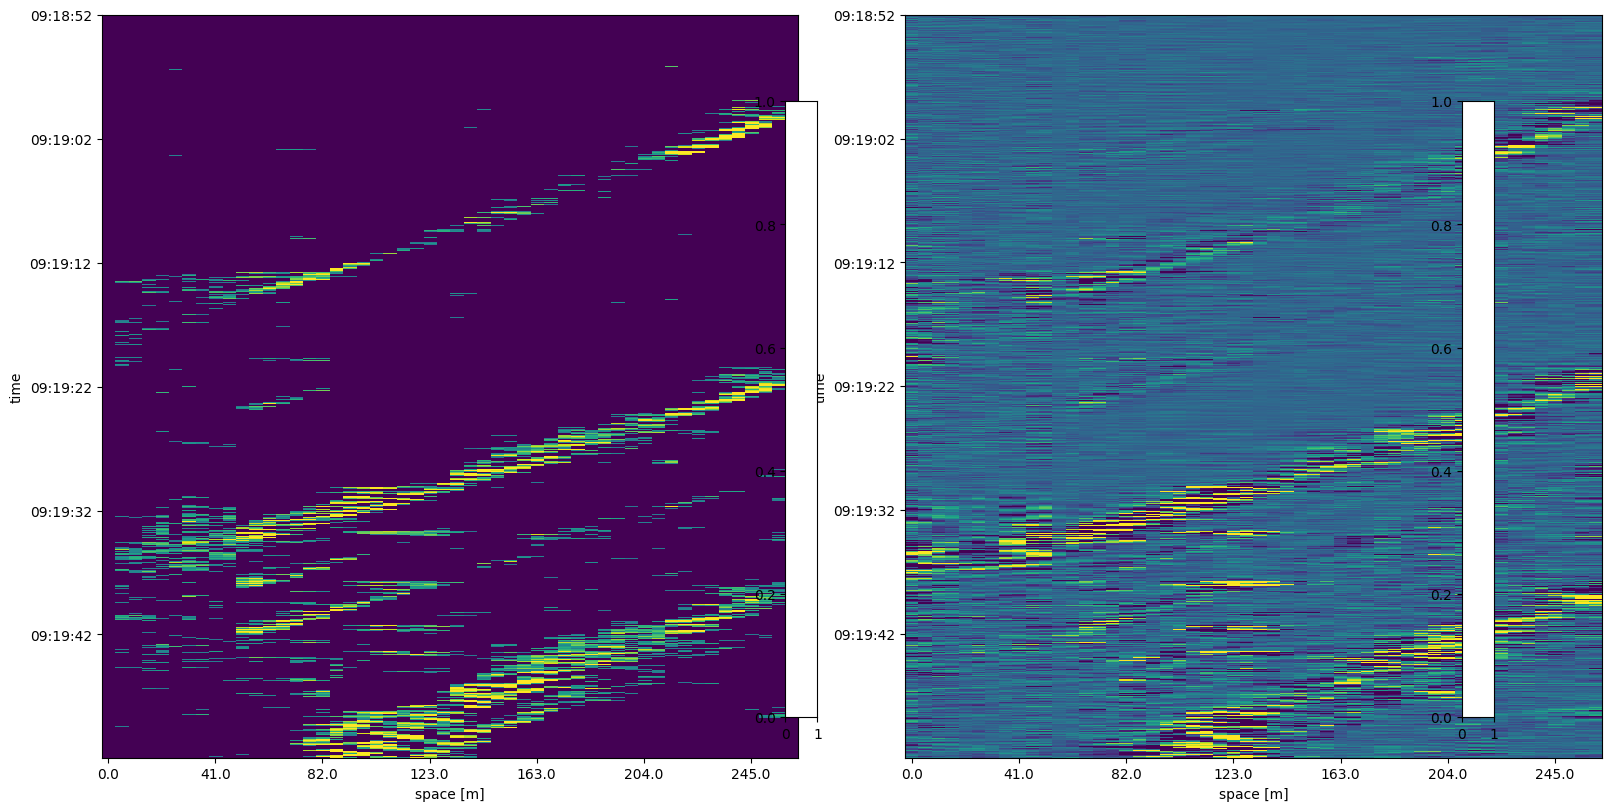

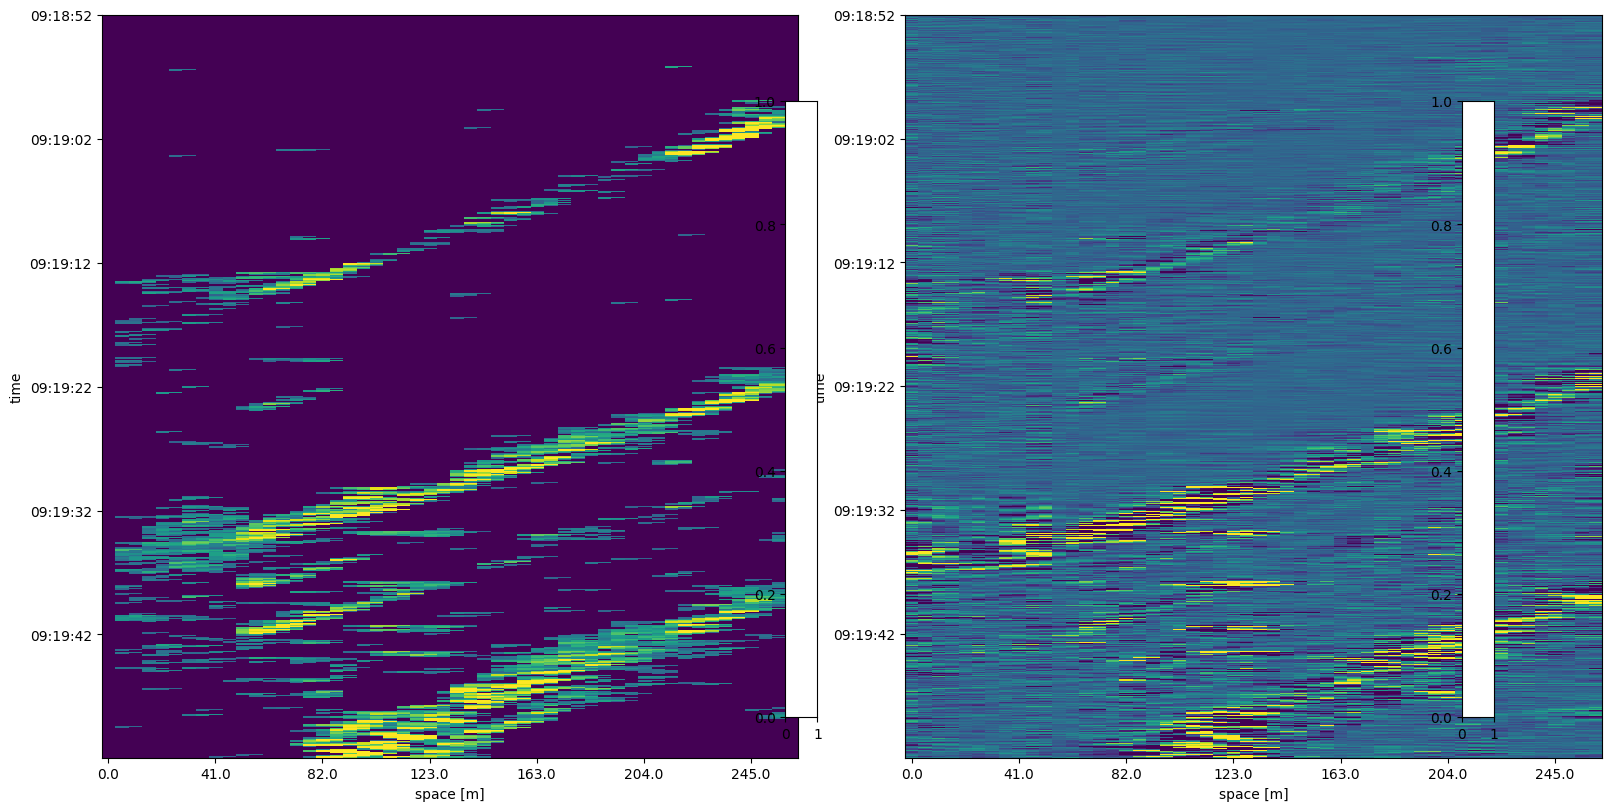

In [373]:
clipped_before = clip_above_percentile(mean_normalized_corrected,98)
plotting_function([clipped_before,mean_normalized_corrected])


now_lowpass = low_pass_filter_percentile(clipped_before,95)
plotting_function([now_lowpass,clipped_before])

#now_downsampled = downsampling_time_median(clipped_before,100)

sob = sobel_filter_vertical(now_lowpass,1)

#now_downsampled = downsampling_time_mean(now_lowpass,50)
plotting_function([sob,now_lowpass])

now_downsampled = downsampling_time_mean(sob,50)

plotting_function([now_lowpass,now_downsampled])

plotting_function([now_downsampled,dfs[0]])

opened = automedian(now_downsampled,2)
plotting_function([opened,dfs[0]])

low_fin = low_pass_filter_all(now_downsampled,92)
plotting_function([low_fin,dfs[0]])


dil_fin = dilate(low_fin,2)
plotting_function([dil_fin,dfs[0]])


## workflow 2

### time downsampling

the data after the time doownsampling on the left and before the time downsampling on the right


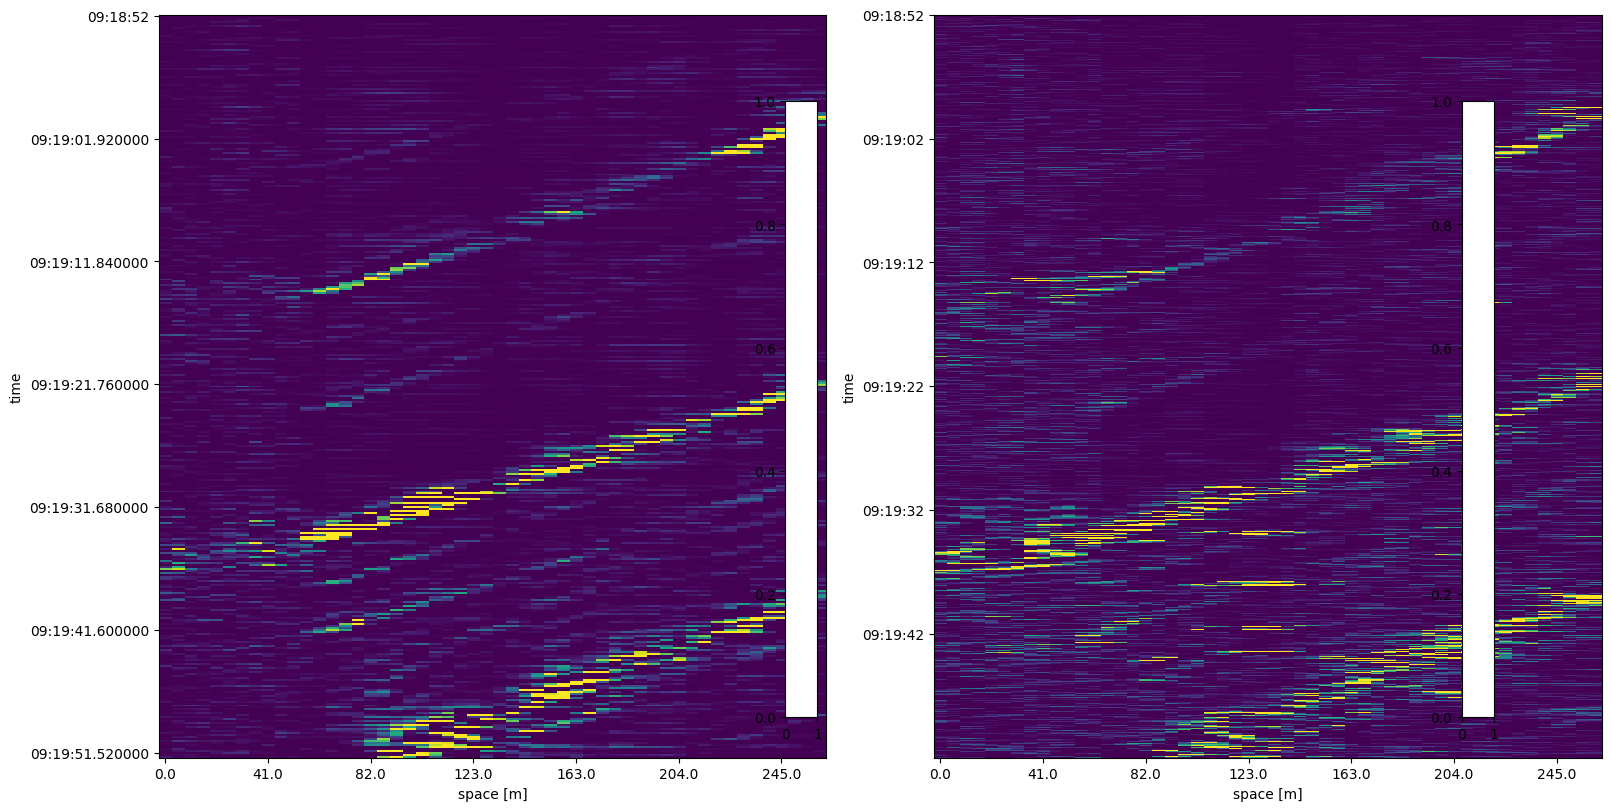

In [374]:
'''the operation of time downsampling which enables us to aggregate the data, for each vehicle sensed into strcture resembling the lines'''
downsampled_median = downsampling_time_median(mean_normalized_corrected,100,True)
print("the data after the time doownsampling on the left and before the time downsampling on the right")
plotting_function([downsampled_median,mean_normalized_corrected],False)




### clipping high values

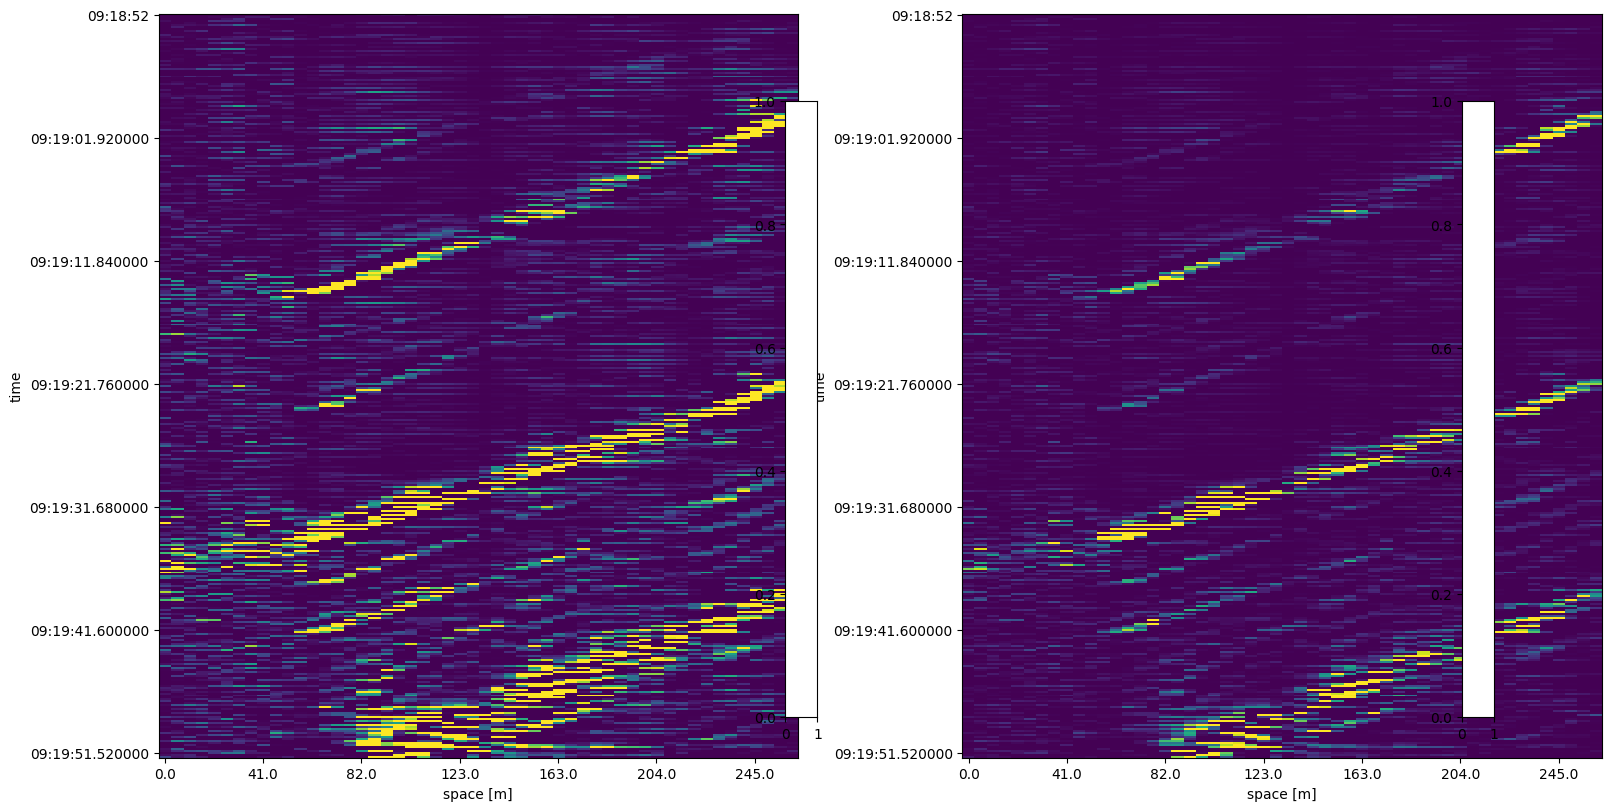

In [375]:
'''clipping the outliers so that the reponse of another lines are more visible '''
clipped_first = clip_above_percentile(downsampled_median,97)
plotting_function([clipped_first,downsampled_median])

### denoising of the time downsampled

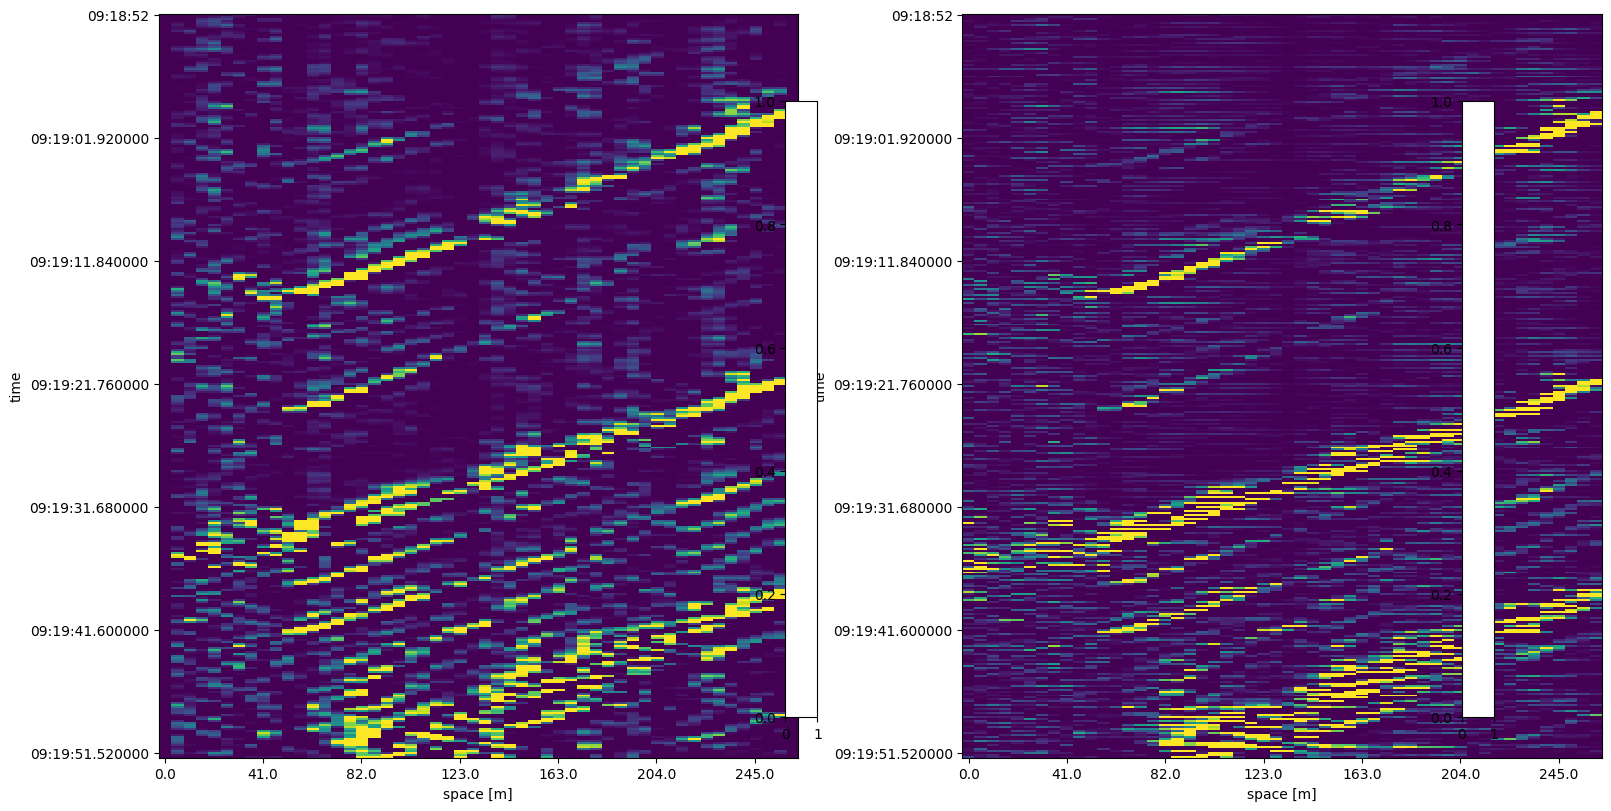

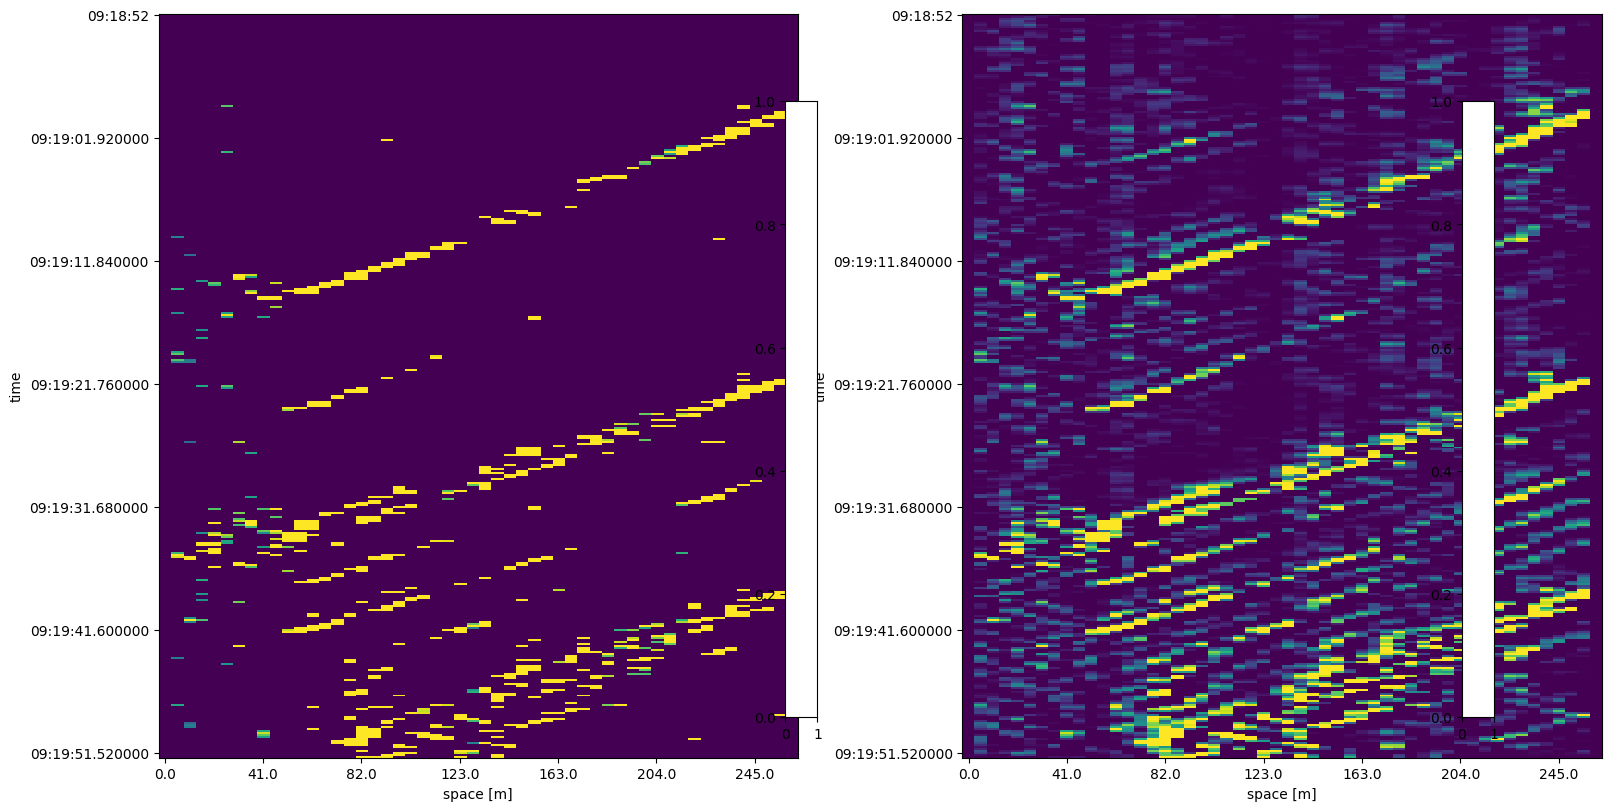

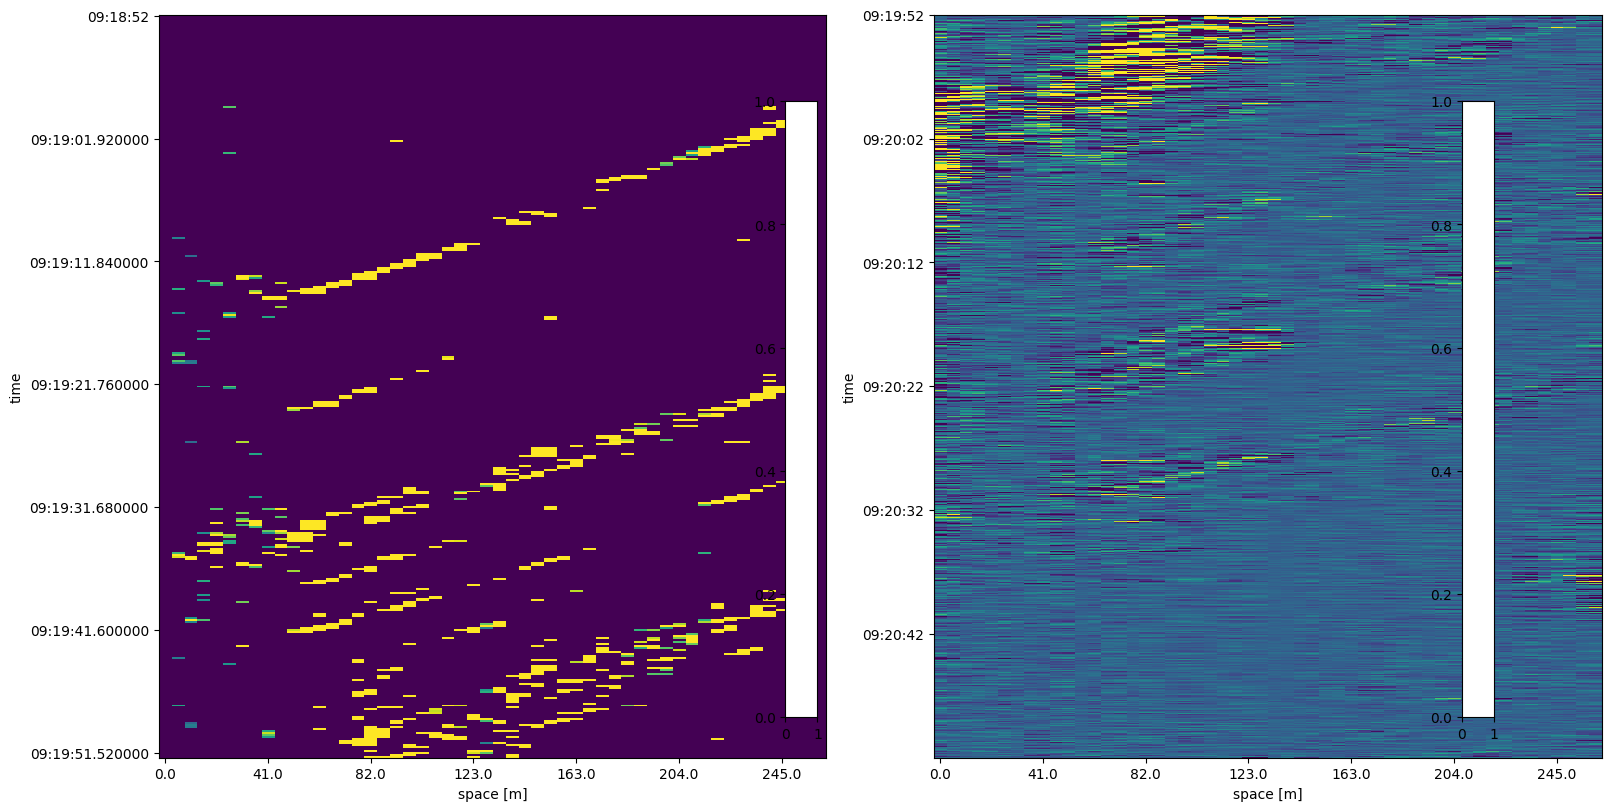

In [376]:


clipped_sobeled = sobel_filter_vertical(clipped_first,0.75)
plotting_function([clipped_sobeled,clipped_first])

clipped_sobeled_lowpass = low_pass_filter_percentile(clipped_sobeled,97)
plotting_function([clipped_sobeled_lowpass,clipped_sobeled])


plotting_function([clipped_sobeled_lowpass,dfs[1]])

# clipped_lowpass = low_pass_filter_percentile(clipped_first,96)
# plotting_function([clipped_lowpass,clipped_first])

# clipped_lowpass_sobeled = sobel_filter_vertical(clipped_lowpass,1)
# plotting_function([clipped_lowpass_sobeled,clipped_lowpass])
# downsampled_percentile_lowpass_2 = low_pass_filter_percentile(downsampled_median_2,90)
# plotting_function([downsampled_percentile_lowpass_2,downsampled_median_2])




### clippig high values

In [369]:
# clipped = clip_above_percentile(downsampled_percentile_lowpass,98)
# plt.imshow(clipped)
# plotting_function([downsampled_percentile_lowpass,clipped],False)
#plt.imshow(downsampled_percentile_lowpass)



### high pass filter

In [370]:
# sobeled = sobel_filter(downsampled_percentile_lowpass,3)
# plotting_function([sobeled,downsampled_percentile_lowpass])

### blur

In [371]:
# blurred = dilate(downsampled_percentile_lowpass,(3,3),True)
# plotting_function([blurred,downsampled_percentile_lowpass])
